<a href="https://colab.research.google.com/github/BJHeemskerk/DeepLearning_2024/blob/main/Opdracht%201/Portfolio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Voorspellen van huisprijzen** <a name='begin'></a>

|Teamleden|Kaggle Username|GitHub Username|
|--|--|--|
|Nima Ghafar|NimaGhafar|NimaGhafar|
|Busse Heemskerk|bussejheemskerk|BJHeemskerk|
|Henry Lau|||
|Jesse van Leeuwen|22096337|22096337|

In deze opdracht is het de bedoeling om verschillende modellen te trainen en testen om te ondervinden welk model het beste is om de huisprijzen te voorspellen. Door dit te bepalen kan er advies worden gegeven aan de makelaars en de algemene huizenmarkt over de waarschijnlijke prijs van een huis.

## Inhoudsopgave
1. [H1: Importeren en inladen](#h1)
2. [H2: EDA](#h2)
3. [H3: Splitsen en Scalen](#h3)
4. [H4: Fully Connected Neural Network](#h4)
5. [H5: Convolutional Neural Network](#h5)
6. [H6: Transfer Learning](#h6)
7. [H7: Multimodaal Model](#h7)
8. [H8: Bevindingen](#h8)
9. [H9: Uitdagingen](#h9)
10. [H10: Conclusie en aanbevelingen](#h10)

## H1: Importeren en inladen <a name='h1'></a>
Eerst zullen de verschillende gebruikte libaries worden geimporteerd.

In [2]:
# Importeren van veel gebruikte libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import datetime
import cv2

# Importeren libaries voor aanpassen/behandelen features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Importeren DL libaries
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, MaxPooling2D, Flatten, concatenate, Rescaling, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from pathlib import Path
from tensorflow.keras.utils import plot_model

ModuleNotFoundError: No module named 'keras_tuner'

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/DeepLearning_2024/Opdracht 1')


Nu zal de data worden ingeladen. Om hiermee te beginnen zullen de csv bestanden worden ingeladen.

In [8]:
# Inladen van csv bestanden
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Tonen van de data
display(train_data.head(), test_data.head())

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
0,1,4,4.0,4053,33.6968,-111.8892,869500
1,2,4,3.0,3343,34.8280,-119.0349,865200
2,3,3,4.0,3923,33.7669,-111.9182,889000
3,4,5,5.0,4022,33.7752,-111.7791,910000
4,5,3,4.0,4116,33.7669,-111.9182,971226


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
0,501,3,2.0,2330,35.6406,-120.7003
1,502,3,2.5,1339,35.6406,-120.7003
2,503,3,2.0,1472,35.6406,-120.7003
3,504,4,4.0,2681,35.6406,-120.7003
4,505,3,2.5,1935,33.8085,-117.9228


In de volgende code cel wordt de data van elke afbeelding in de train en de test map opgehaald.

In [9]:
# Aanmaken van te vullen lijsten
file_paths_tr = []
imgdata_tr = []
file_paths_te = []
imgdata_te = []

# Opzetten directories
directories = ["Train", "Test"]

# Ophalen van de bestanden
# Loopen over directories
for directory in directories:
    directory_path = os.path.join('/content/drive/My Drive/Colab Notebooks/DeepLearning_2024/Opdracht 1', directory)
    # Loopen over alle bestanden
    for file in os.listdir(directory_path):
        # Alleen checken van .jpg bestanden
        if file.endswith(".jpg"):
            # Aanmaken van pad naar het bestand.
            file_path = os.path.join(directory_path, file)

            # Openen van de afbeelding en omzetten naar np.array
            img = Image.open(file_path)
            img_array = np.array(img)

            # Vullen van juiste lijsten op basis van ID
            if int(file.split('.')[0]) > 500:  # We halen de ID uit de bestandsnaam
                file_paths_te.append(file_path)
                imgdata_te.append(img_array)
            else:
                file_paths_tr.append(file_path)
                imgdata_tr.append(img_array)


In [10]:
# Aanmaken van te vullen lijsten
file_paths_tr = []
imgdata_tr = []
file_paths_te = []
imgdata_te = []

# Opzetten directories
directories = ["train/", "test/"]

# Ophalen van de bestanden
# Loopen over directories
for directory in directories:
    # Loopen over alle bestanden
    for file in os.listdir(directory):
        # Alleen checken van .jpg bestanden
        if file.endswith(".jpg"):
            # Aanmaken van pad naar het bestand.
            file_path = os.path.join(directory, file)

            # Openen van de afbeelding en omzetten naar np.array
            img = Image.open(file_path)
            img_array = np.array(img)

            # Ophalen numerieke ID van het beastand
            file_number = ''.join(filter(str.isdigit, file))

            # Vullen van juiste lijsten op basis van ID
            if file_number and int(file_number) > 500:
                file_paths_te.append(file_path)
                imgdata_te.append(img_array)
            else:
                file_paths_tr.append(file_path)
                imgdata_tr.append(img_array)

FileNotFoundError: [Errno 2] No such file or directory: 'train/'

Nu alle data in lijsten is gezet kunnen er dataframes worden aangemaakt met de data van de afbeeldingen. Door de grootte van de arrays kan dit even duren.

In [11]:
# Initieren van het dataframe
train_images = pd.DataFrame(columns=["House ID", "FilePath", "ImgData"])
test_images = pd.DataFrame(columns=["House ID", "FilePath", "ImgData"])

# Aanvullen train dataset
train_images["House ID"] = train_data["House ID"]
train_images["FilePath"] = file_paths_tr
train_images["ImgData"] = imgdata_tr

# Aanvullen test dataset
test_images["House ID"] = test_data["House ID"]
test_images["FilePath"] = file_paths_te
test_images["ImgData"] = imgdata_te

# Tonen van de dataframes
display(train_images.head(), test_images.head())

ValueError: Length of values (0) does not match length of index (500)

Vervolgens zullen de dataframes worden getest door de afbeeldingen te tonen.

In [12]:
# Ophalen van pad naar afbeelding
image_path = train_images["FilePath"][0]

# Openen afbeelding
img = Image.open(image_path)

# Omzetten afbeelding naar np.array
img_array = np.array(img)

# Tonen van de afbeelding
plt.imshow(img)
plt.show()

# Opnieuw tonen van de afbeelding via DF
plt.imshow(train_images["ImgData"][0])
plt.show()

AttributeError: 'float' object has no attribute 'read'

[Terug naar boven](#begin)

## H2: EDA <a name='h2'></a>

Met alle data ingeladen is het mogelijk om de data te gaan onderzoeken. Om hieraan te beginnen zal er gekeken worden naar de opmaak van de afbeeldingen.

In [13]:
# Maken van figuur voor afbeeldingen
plt.figure(figsize=(10, 10))
for i in range(9):
    # Maken van een subplot
    plt.subplot(3, 3, i + 1)

    # Inladen van de afbeelding
    plt.imshow(train_images["ImgData"][i])
    plt.axis('off')

# Tonen van afbeelding grootte
print(f"Afbeelding lengte en breedte: {train_images["ImgData"][0].shape}")

SyntaxError: f-string: unmatched '[' (<ipython-input-13-aa47533a640a>, line 12)

Voor de afbeeldingen is er sprake van een 3 dimensionale arrays waarin de data is opgeslagen. Met een grootte van (1024, 1024, 3) is er sprake van het volgende:
- Er zijn in totaal 1024 pixels (opgeslagen in kleine arrays) per afbeelding in zowel de lengte als de breedte.
- Elke array is drie getallen groot, deze getallen zijn de RGB getallen.

Met deze informatie is het mogelijk om later neurale netwerken op te stellen met de afbeeldingen als input. Voor andere neurale netwerken zal er gebruik worden gemaakt van de metadata die in het excel bestand beschikbaar is. Deze data zal nu worden bekeken en geanalyseerd.

In [14]:
# Bekijken van de kolom statistieken
print("Train dataframe kolom statistieken:")
display(train_data.describe(include='all'))

# Bekijken missende waarden en data-typen
print("Train dataframe kolom informatie:")
display(train_data.info())

Train dataframe kolom statistieken:


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,5.000000e+02
mean,250.500000,3.350000,2.669500,2369.64600,35.128844,-116.469049,5.980218e+05
std,144.481833,1.172283,1.017578,1208.18261,2.386173,6.554434,5.240649e+05
min,1.000000,1.000000,1.000000,701.00000,32.631500,-122.368300,2.200000e+04
25%,125.750000,2.000000,2.000000,1440.00000,33.808200,-119.802500,2.350000e+05
50%,250.500000,3.000000,2.500000,2097.50000,33.920800,-117.609600,5.300000e+05
75%,375.250000,4.000000,3.000000,3104.50000,35.640600,-116.371300,7.490000e+05
max,500.000000,10.000000,7.000000,9583.00000,47.791800,-87.885900,5.858000e+06


Train dataframe kolom informatie:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB


None

Van de vijf verschillende feature kolommen, dit zijn Bedrooms, Bathrooms, Area, Latitude en Longitude, is er geen sprake van aanwezige nul- of missende waarden. Ook in de target kolom zijn geen missende waarden te vinden. Echter zijn de waarden lastig te interpreteren voorsommige machine learning modellen, omdat de features erg verschillen qua grootte. Om dit op te lossen zal de data worden gescaled na het toepassen van train_test_split in de volgende paragraaf. Op deze manier zal de Price kolom niet worden aangepast.

Nu zal er gekeken worden naar de test dataset.

In [15]:
# Bekijken van de kolom statistieken
print("Test dataframe kolom statistieken:")
display(test_data.describe(include='all'))

# Bekijken missende waarden en data-typen
print("Test dataframe kolom informatie:")
display(test_data.info())

Test dataframe kolom statistieken:


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,518.000000,3.771429,2.600000,2297.171429,36.631043,-120.662114
std,10.246951,0.910259,0.591608,1457.127886,1.837672,1.670038
min,501.000000,2.000000,1.500000,987.000000,33.808500,-121.775800
25%,509.500000,3.000000,2.000000,1580.000000,34.724550,-121.775800
50%,518.000000,4.000000,2.500000,2012.000000,37.965800,-121.775800
75%,526.500000,4.000000,3.000000,2387.500000,37.965800,-119.311550
max,535.000000,7.000000,4.000000,9536.000000,37.965800,-117.922800


Test dataframe kolom informatie:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   35 non-null     int64  
 1   Bedrooms   35 non-null     int64  
 2   Bathrooms  35 non-null     float64
 3   Area       35 non-null     int64  
 4   Latitude   35 non-null     float64
 5   Longitude  35 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 1.8 KB


None

Alle opmerkingen over de train dataset gelden ook voor de test dataset. Er zijn geen nul- of missende waarden aanwezig en de enige toepassing die nodig lijkt is het scalen van de data.

Verder zal er aan de hand van verschillende visualisaties meer kennis worden opgedaan over de data.

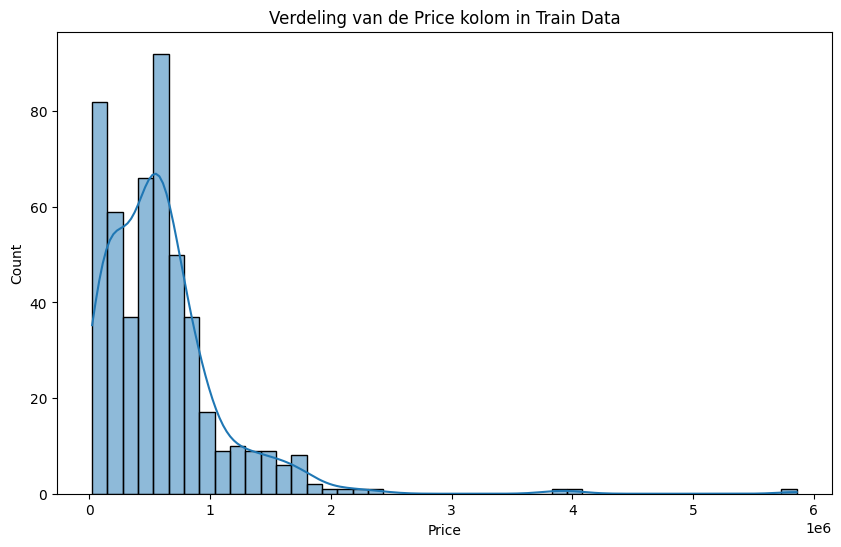

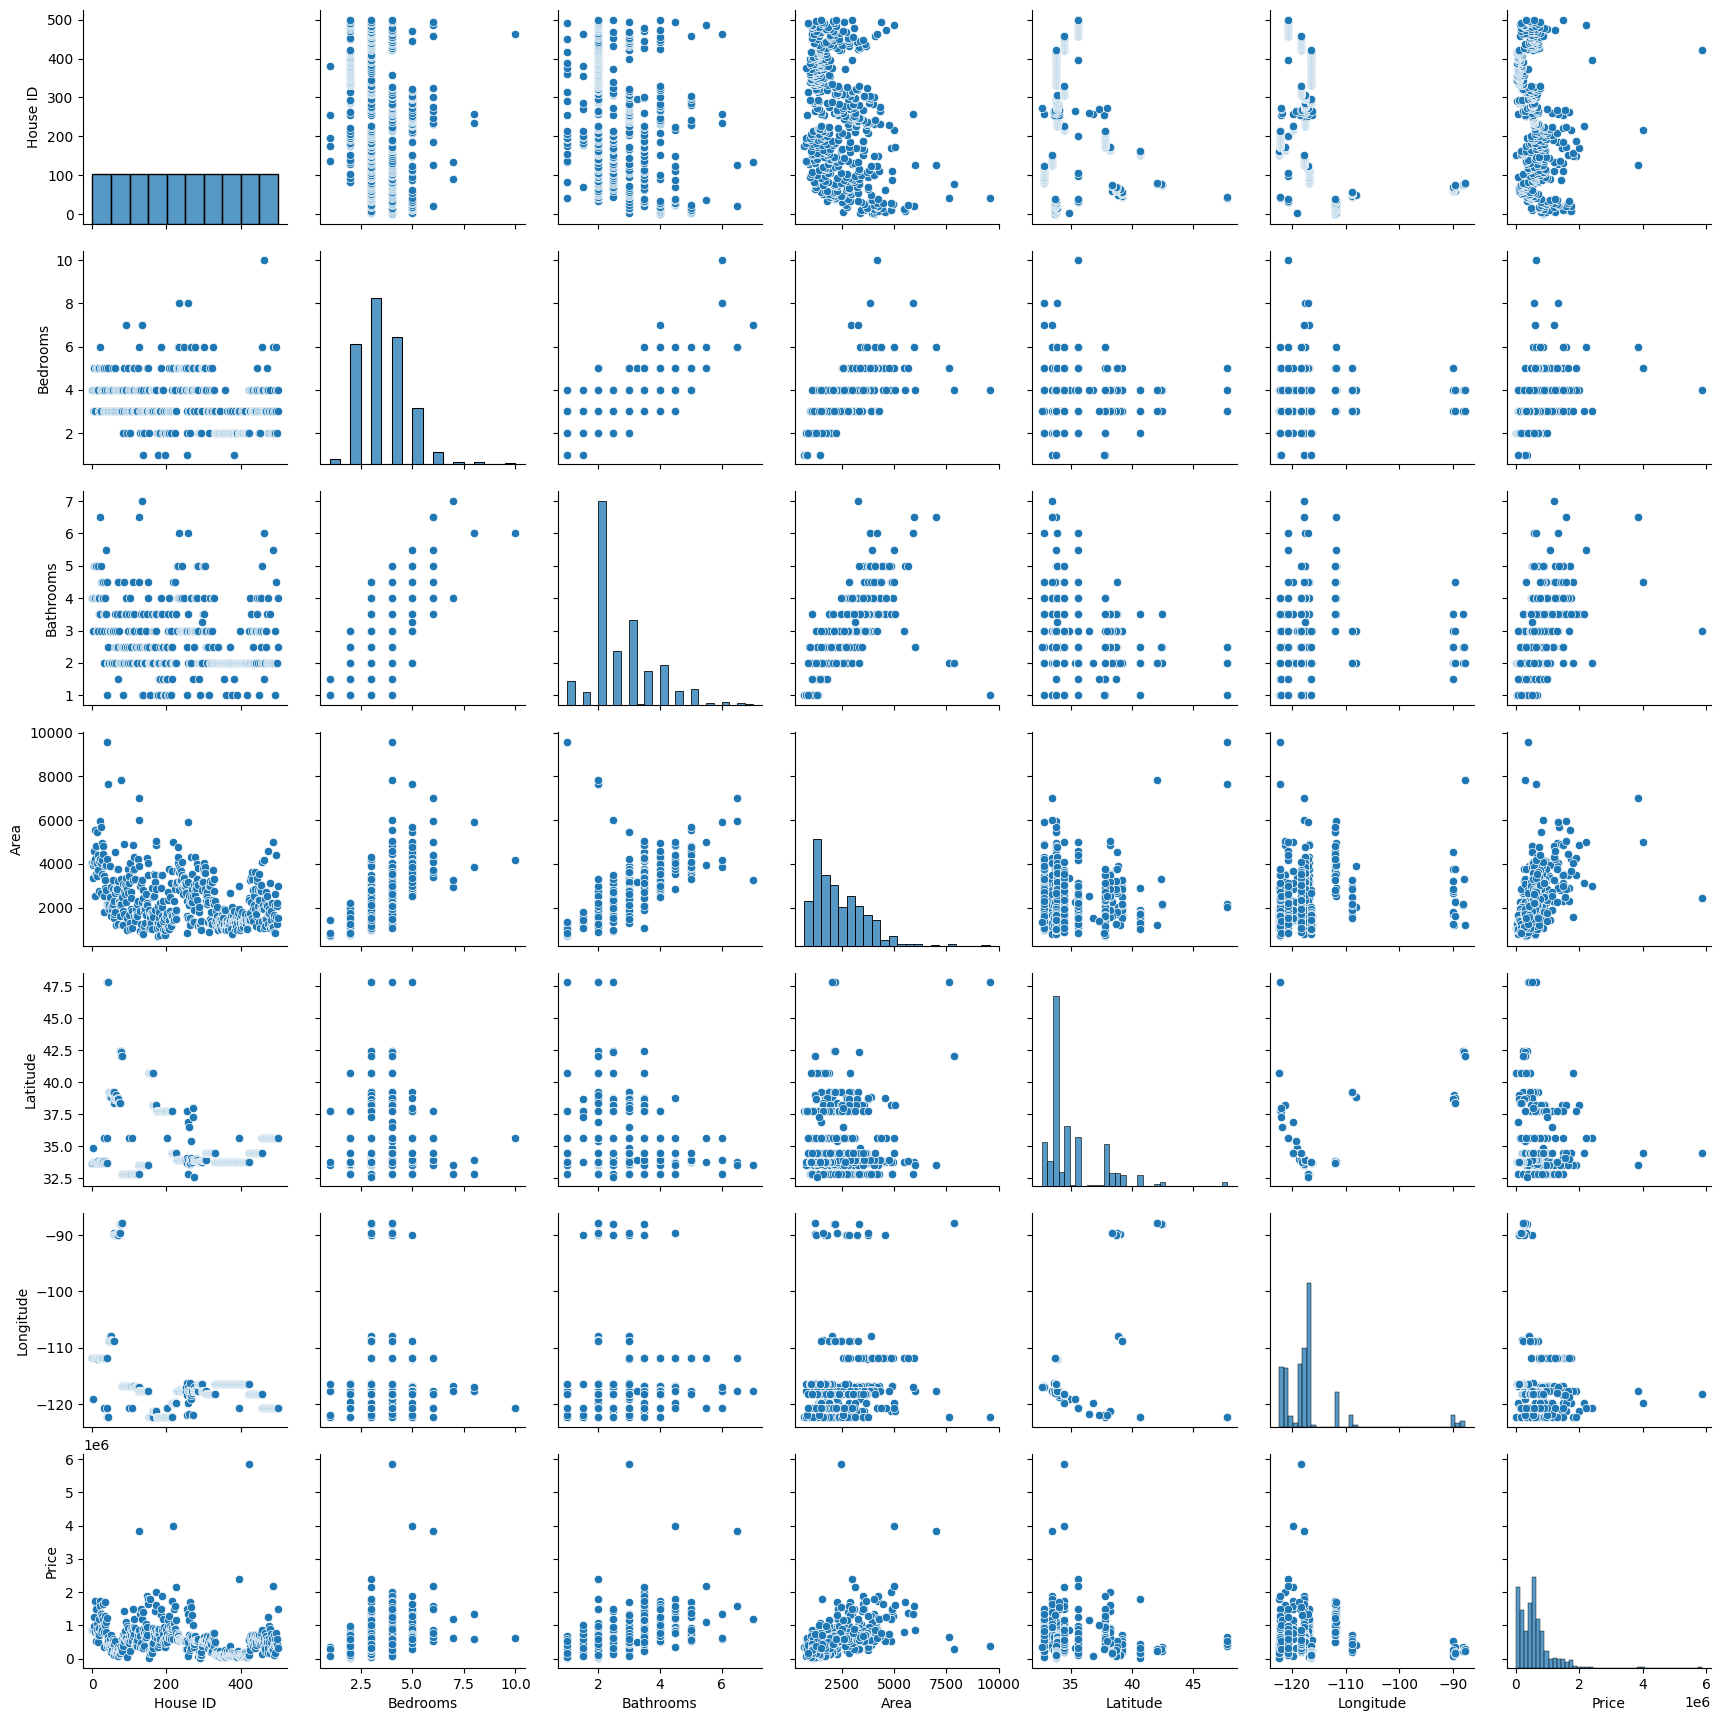

In [16]:
# Visualize the distribution of the target variable in the train dataframe
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Price'], kde=True)
plt.title('Verdeling van de Price kolom in Train Data')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

sns.pairplot(train_data)
plt.show()

Bij de verdeling van de prijs kolom is sprake van een sterke rechts-scheve verdeling. Dit ligt gedeeltelijk aan de paar aanwezige outliers in de data, maar ook aan de distributie van de waarden. In het blok dat meer bij elkaar ligt zit de piek namelijk niet in het midden, maar meer aan de rechter kant.

Bij de scatterplots van de price kolom met de andere feature is te zien dat het meerendeel van de features enige positieve correlatie heeft met de prijs. Om dit echter verder te onderzoeken zullen er heatmaps worden aangemaakt.

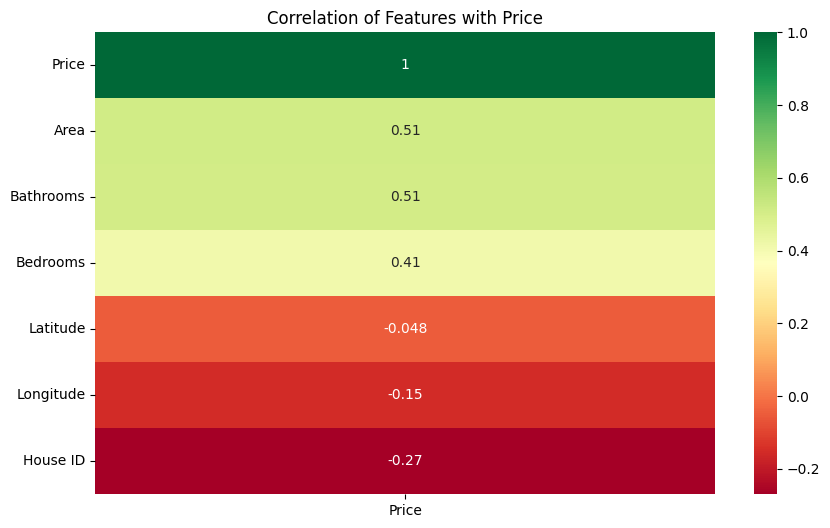

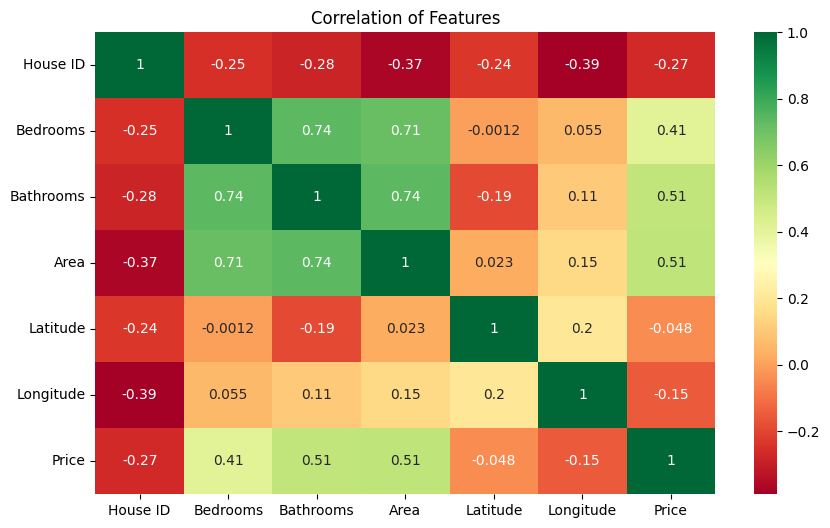

In [17]:
# Maak een heatmap met  cmap='RdYlGn' alleen op "Price" in de train dataframe en in volgorde van hoog naar laag
plt.figure(figsize=(10, 6))
sns.heatmap(train_data.corr()[['Price']].sort_values(by='Price', ascending=False), annot=True, cmap='RdYlGn')
plt.title('Correlation of Features with Price')
plt.show()

# Maak een heatmap met  cmap='RdYlGn' voor alle kolommen in de train dataframe en in volgorde van hoog naar laag

plt.figure(figsize=(10, 6))
sns.heatmap(train_data.corr(), annot=True, cmap='RdYlGn')
plt.title('Correlation of Features')
plt.show()


Bij de features latitude (corr = -0.048) en longitude (corr = -0.15) is de correlatie het kleinste en deze waarden zijn als enige negatief. De correlaties bij Bedrooms (corr = 0.41) en Bathrooms (corr = 0.51) zijn al sterker, maar ook niet extreem overtuigend. De correlatie met de area kolom is gelijk aan die van Bathrooms, met een waarde van 0.51. Correlaties van 0.5 worden beschouwd als een gematigde positieve correlatie.

Tussen de features zelf is er nauwelijks sprake van sterke correlaties. De enige twee kolommen die sterker correleren zijn Bedrooms en Bathrooms. Echter waarborgd een correlatie van 0.7 nog geen zorgen op en hoeft er volgens ons niks te worden aangepast aan deze kolommen.

[Terug naar boven](#begin)

## H3: Splitsen en scalen <a name='h3'></a>

Voordat er neurale netwerken kunnen worden opgesteld, zal eerst nog de train_data dataset worden opgesplitst in een test en een validatie set.

In [18]:
# Aanmaken van de random_state SEED
SEED = 42

# Opslitsten van data in X en y
X = train_data.drop(['House ID', 'Price'], axis=1)
y = train_data['Price']

# Toepassen van train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, test_size=0.1, random_state=SEED
                                       )

Nu volgt het scalen van de feature data, dit zorgt ervoor dat het model betere verbanden kan leggen tussen de verschillende variabelen.

In [19]:
# Scalen van de gesplitste data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Scalen van de test_data
# Aanmaken lijst met nodige kolomnamen
kolomnamen = ["Bedrooms", "Bathrooms", "Area", "Latitude", "Longitude"]

# Scalen van de nodige kolommen
test_fe = test_data[kolomnamen]
sc_test_fe = scaler.fit_transform(test_fe)

[Terug naar boven](#begin)

## H4: Fully Connencted Neural Network <a name='h4'></a>

Nu kan er worden begonnen met het opzetten van verschillende voorspellingen. Het eerste type voorspelling dat voor zal komen is een Fully Connected Neural Network. Dit netwerk bestaat uit de volgende lagen:

**Input laag:**<br>
De input laag van een neuraal netwerk bestaat uit een bepaald aantal neuronen. Het aantal neuronen moet gelijk zijn aan het aantal features dat in de dataset beschikbaar is. In onze datasets zijn er 5 features te vinden, dus heeft de input laag 5 neuronen.

In alle hidden layers is gebruik gemaakt van een trial & error aanpak, waarmee er met verschillende hoeveelheden van neuronen en verschillende activatie functies is getest. Uiteindelijk kwamen hier de volgende aantallen en activaties uit:

**Hidden Layer 1:**<br>
- Neuronen: 128
- Activatie: Rectified Linear Unit

**Hidden Layer 2:**<br>
- Neuronen: 64
- Activatie: Rectified Linear Unit

**Hidden Layer 3:**<br>
- Neuronen: 64
- Activatie: Rectified Linear Unit

**Hidden Layer 4:**<br>
- Neuronen: 16
- Activatie: Rectified Linear Unit

Voor de output laag geldt ongeveer hetzelfde als voor de input laag. Het aantal neuronen in de output laag hoort gelijk te zijn aan het aantal klassen die worden voorspeld bij classificatie. Bij regressie taken is er vaak maar 1 neuron in de output laag aanwezig, omdat er een eenvoudige numerieke voorspelling wordt gemaakt. In ons regressie probleem is deze waarde de huisprijs. Bij regressie is er ook sprake van de activatie functie 'linear', ookwel bekend als geen activatie.

In [20]:
# Aanmaken NN mbv Sequential API
fcnn = Sequential()

# Toevoegen input en eerste hidden layer
fcnn.add(Dense(128, input_shape=(5,), activation='relu'))

# Toevoegen andere hidden layers
fcnn.add(Dense(64, activation='relu'))
fcnn.add(Dense(64, activation='relu'))
fcnn.add(Dense(16, activation='relu'))

# Toevoegen van output layer
fcnn.add(Dense(1, activation='linear'))

Nadat alle lagen van het model zijn opgesteld, is het tijd om het model te compilen. Deze stap voegt enkele parameters toe aan het model:
- De optimizer, een algoritme dat bepaalt op welke wijze het model leert tijdens het trainen.
- De loss functie, een functie die aantoont hoe goed het model presteert op de gegevens.
- De metric, een extra, optionele meetwaarde voor de prestatie van het model.

Voor ons model is er gekozen voor de volgende parameters:
- De Adam (Adaptive Moment estimator) optimizer
- Mean Squared Error als metric
- Mean Absolute Percentage Error als loss.

Als loss is er gekozen voor de MAPE, omdat deze metric ook wordt gebruikt in de kaggle competitie. De mean squared error is een vetrouwbare functie die veel wordt gebruikt in Machine Learning en geeft een goede indicatie over de precisie van de voorspelling, om deze reden is er gekozen om de MSE als metric erbij te gebruiken. De Adam optimizer is een van de meest populaire optimizers voor Neurale Netwerken en is hierom ook gekozen bij dit model. De adam (Adaptive Moment Estimation) optimizer gebruikt twee moving averages per parameter, waarmee de optimizer de learning rate voor de voorspelling dynamisch aanpast tijdens het trainings proces. Als basis is er een learning rate van 0.001 gekozen. Omdat er verwacht wordt dat het huidige model niet de beste zal zijn, is er gekozen om nog geen gevisualiseerde modelstructuur te tonen.

Daarnaast is er ook een module aangemaakt om het model eerder te kunnen stoppen, in het geval dat er niet veel meer veranderd aan de loss van de validatie data.

In [21]:
# Compilen van het model
fcnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_absolute_percentage_error',
    metrics=['mean_squared_error']
)

# Maken van een vroege stop module
early_stop = EarlyStopping(
    monitor='val_loss', patience=50, restore_best_weights=True
    )

Nu alles is aangemaakt kan het model worden getrained. Hierbij gebruiken we de trainings data, de validatie data, een gekozen aantal epochs, een batch size en een callback module. De epochs staan voor het aantal iteraties dat het model door zal gaan, door gebruik van de callback module is er gekozen om 5000 epochs uit te voeren. Zodra de loss op de validatie set voor 50 epochs niet genoeg veranderd zal het model automatisch stoppen en worden de parameters van de beste epoch hersteld. De batch size wijst op het aantal datapunten dat per epoch wordt gebruikt, bij ons is er gekozen voor een batch size van 4.

In [22]:
# Fitten van het model met de data
h_fcnn = fcnn.fit(
    X_train, y_train,
    batch_size=4,
    epochs=5000,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/5000
113/113 [==============================] - 5s 6ms/step - loss: 99.9803 - mean_squared_error: 646670188544.0000 - val_loss: 99.8282 - val_mean_squared_error: 496275718144.0000
Epoch 2/5000
113/113 [==============================] - 0s 4ms/step - loss: 97.4648 - mean_squared_error: 640626393088.0000 - val_loss: 88.5287 - val_mean_squared_error: 475301281792.0000
Epoch 3/5000
113/113 [==============================] - 0s 4ms/step - loss: 79.9605 - mean_squared_error: 584617492480.0000 - val_loss: 72.0056 - val_mean_squared_error: 403146932224.0000
Epoch 4/5000
113/113 [==============================] - 0s 4ms/step - loss: 73.0669 - mean_squared_error: 526030995456.0000 - val_loss: 68.2745 - val_mean_squared_error: 360977661952.0000
Epoch 5/5000
113/113 [==============================] - 1s 4ms/step - loss: 67.3154 - mean_squared_error: 473319342080.0000 - val_loss: 64.3413 - val_mean_squared_error: 309918498816.0000
Epoch 6/5000
113/113 [==============================] - 0s 4

Met het getrainde model kan er gekeken worden naar de loss van de train data en de validatie data. Op deze manier kan er in een enkele grafiek worden gezien of er sprake is van overfitting of andere problemen.

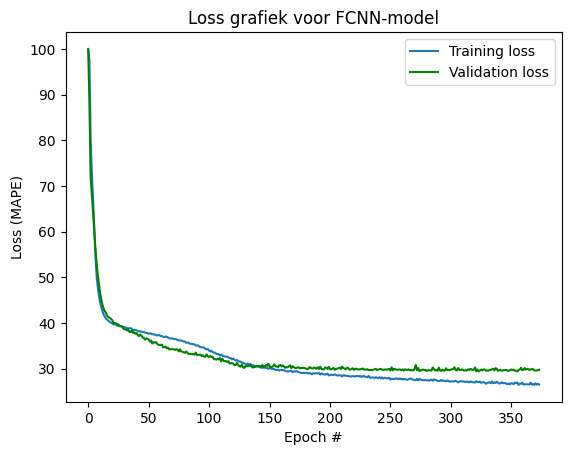

In [23]:
plt.plot(h_fcnn.history['loss'], label='Training loss')
plt.plot(h_fcnn.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MAPE)')
plt.title('Loss grafiek voor FCNN-model')
plt.legend()
plt.show()

Zoals in de grafiek is te zien, is er sprake van geen van overfitting. Overfitting wordt namelijk aangeduid door het stijgen van de validatie loss.

Nu het model is getrained en de loss is bekeken, kan de voorspelling worden geupload naar kaggle. Aan de hand van de voorspellingen kan er een csv bestand aangemaakt worden voor de kaggle competitie. Omdat deze bestanden vaker moeten worden aangemaakt en om de bestanden overzichtelijk en uniform te houden is hiervoor een functie aangemaakt.

In [22]:
def kaggle_csv(model, input_, suffix):
    """
    Deze functie maakt de voorspelling op de test dataset
    en vormt deze om tot een csv bestand om in te kunnen
    leveren op Kaggle.

    Parameters:
    ----------
    model : ML-model of DL-model
        De naam die is gegeven aan het ML-model of DL-model
        dat wordt gebruikt om te voorspellen

    suffix : str
        De 'tag' voor de naam van het csv
        bestand, zodat deze makkelijk te identificeren
        is na de submission.

    Returns:
    ----------
    None
        In plaats van een return maakt het een bestand
        aan in de map Kaggle Submissions. De namen zien
        er als volgt uit:

    """
    # Aanmaken van de voorspelling
    y_pred = model.predict(input_)

    # Aanmaken df met alleen House ID en Price
    test_predictions_df = pd.DataFrame(
        {'House ID': test_data['House ID'],
        'Price': np.ravel(y_pred)})

    # Aanmaken van tijd
    tijd = datetime.datetime.now().strftime("%m%d%H%M%S")

    # Aanmaken csv bestand met timestamp
    test_predictions_df.to_csv(
        f'Kaggle/voorspelling_{suffix}_{tijd}.csv',
        index=False)

    # Print voor conformatie
    print(f'voorspelling_{suffix}_{tijd}.csv has been saved!')

Nu zal de functie worden uitgevoerd om de voorspellingen te verkrijgen.

In [23]:
# Uitvoeren van kaggle_csv functie
kaggle_csv(fcnn, sc_test_fe, 'FCNN-1.1')

2/2 [==============================] - 0s 9ms/step
voorspelling_FCNN-1.1_0328134340.csv has been saved!


In [ ]:
model_save_path = '/content/drive/My Drive/Colab Notebooks/DeepLearning_2024/Opdracht 1/modelversies/fcnn_model_v1.h5'
fcnn.save(model_save_path)


In [ ]:
from tensorflow.keras.models import load_model


model_load_path = '/content/drive/My Drive/Colab Notebooks/DeepLearning_2024/Opdracht 1/modelversies/fcnn_model_v1.h5'


model = load_model(model_load_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 14241 (55.63 KB)
Trainable params: 14241 (55.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### tuning van het model


In [25]:
fcnn_2 = Sequential()

# Toevoegen input en eerste hidden layer met dropout
fcnn_2.add(Dense(64, input_shape=(5,), activation='relu'))
fcnn_2.add(Dropout(0.1))

# Toevoegen andere hidden layers met dropout
fcnn_2.add(Dense(32, activation='relu'))
fcnn_2.add(Dropout(0.1))
fcnn_2.add(Dense(32, activation='relu'))
fcnn_2.add(Dropout(0.1))
fcnn_2.add(Dense(8, activation='relu'))
fcnn_2.add(Dropout(0.1))
fcnn_2.add(Dense(1, activation='linear'))

fcnn_2.compile(
    optimizer=Adam(learning_rate=0.0005), # Aangepaste learning rate
    loss='mean_absolute_percentage_error',
    metrics=['mean_squared_error']
)

early_stop_2 = EarlyStopping(
    monitor='val_loss', patience=50, restore_best_weights=True
)

h_fcnn_2 = fcnn_2.fit(
    X_train, y_train,
    batch_size=8, # Aangepaste batch size
    epochs=5000,
    validation_data=(X_test, y_test),
    callbacks=[early_stop_2]
)

Epoch 1/5000
57/57 [==============================] - 4s 13ms/step - loss: 99.9999 - mean_squared_error: 646733299712.0000 - val_loss: 99.9997 - val_mean_squared_error: 496645242880.0000
Epoch 2/5000
57/57 [==============================] - 0s 4ms/step - loss: 99.9996 - mean_squared_error: 646732775424.0000 - val_loss: 99.9989 - val_mean_squared_error: 496643538944.0000
Epoch 3/5000
57/57 [==============================] - 0s 7ms/step - loss: 99.9980 - mean_squared_error: 646728712192.0000 - val_loss: 99.9951 - val_mean_squared_error: 496636002304.0000
Epoch 4/5000
57/57 [==============================] - 0s 8ms/step - loss: 99.9921 - mean_squared_error: 646714818560.0000 - val_loss: 99.9811 - val_mean_squared_error: 496607723520.0000
Epoch 5/5000
57/57 [==============================] - 0s 6ms/step - loss: 99.9709 - mean_squared_error: 646658129920.0000 - val_loss: 99.9358 - val_mean_squared_error: 496517775360.0000
Epoch 6/5000
57/57 [==============================] - 0s 7ms/step - l

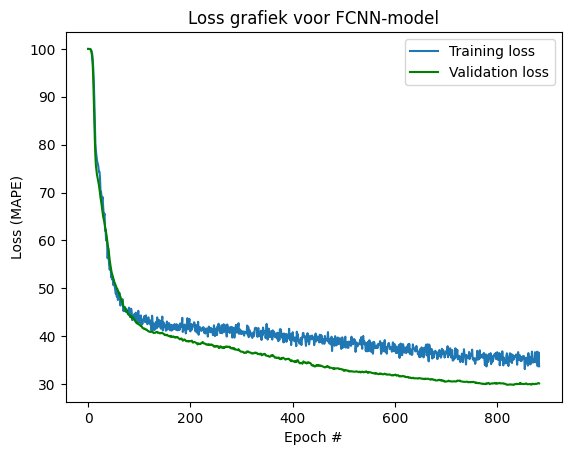

In [26]:
plt.plot(h_fcnn_2.history['loss'], label='Training loss')
plt.plot(h_fcnn_2.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MAPE)')
plt.title('Loss grafiek voor FCNN-model')
plt.legend()
plt.show()

In [28]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

fcnn_3 = Sequential()

# Toevoegen van input en eerste hidden layer met L2 regularization en dropout
fcnn_3.add(Dense(64, input_shape=(5,), activation='relu', kernel_regularizer=l2(0.01)))
fcnn_3.add(Dropout(0.1))

# Toevoegen van andere hidden layers met L2 regularization en dropout
fcnn_3.add(Dense(48, activation='relu', kernel_regularizer=l2(0.01)))
fcnn_3.add(Dropout(0.1))
fcnn_3.add(Dense(48, activation='relu', kernel_regularizer=l2(0.01)))
fcnn_3.add(Dropout(0.1))
fcnn_3.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
fcnn_3.add(Dropout(0.1))

# Toevoegen van de output layer
fcnn_3.add(Dense(1, activation='linear'))

# Compilen van het model
fcnn_3.compile(
    optimizer=Adam(learning_rate=0.001),  # Aangepaste lagere learning rate
    loss='mean_absolute_percentage_error',
    metrics=['mean_squared_error']
)

# Maken van een vroege stop module
early_stop_3 = EarlyStopping(
    monitor='val_loss', patience=100, restore_best_weights=True  # Verhoogde patience
)

# Fitten van het model met de data
h_fcnn_3 = fcnn_3.fit(
    X_train, y_train,
    batch_size=32,  # Verhoogde batch size
    epochs=5000,
    validation_data=(X_test, y_test),
    callbacks=[early_stop_3]
)

Epoch 1/5000
15/15 [==============================] - 3s 19ms/step - loss: 101.3541 - mean_squared_error: 646733168640.0000 - val_loss: 101.3404 - val_mean_squared_error: 496645275648.0000
Epoch 2/5000
15/15 [==============================] - 0s 5ms/step - loss: 101.3300 - mean_squared_error: 646733103104.0000 - val_loss: 101.3166 - val_mean_squared_error: 496645275648.0000
Epoch 3/5000
15/15 [==============================] - 0s 6ms/step - loss: 101.3064 - mean_squared_error: 646733103104.0000 - val_loss: 101.2932 - val_mean_squared_error: 496645242880.0000
Epoch 4/5000
15/15 [==============================] - 0s 7ms/step - loss: 101.2831 - mean_squared_error: 646733103104.0000 - val_loss: 101.2701 - val_mean_squared_error: 496645242880.0000
Epoch 5/5000
15/15 [==============================] - 0s 5ms/step - loss: 101.2603 - mean_squared_error: 646733103104.0000 - val_loss: 101.2475 - val_mean_squared_error: 496645177344.0000
Epoch 6/5000
15/15 [==============================] - 0s 6m

In [1]:
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    model = Sequential()

    # Input en eerste hidden layer
    model.add(Dense(
        hp.Int('units_first', min_value=32, max_value=256, step=32),
        input_shape=(5,),
        activation='relu'
    ))

    # Meerdere hidden layers
    for i in range(hp.Int('num_hidden_layers', 1, 4)):
        model.add(Dense(
            hp.Int(f'units_hidden_{i}', min_value=32, max_value=256, step=32),
            activation='relu'
        ))
        model.add(Dropout(hp.Float('dropout', min_value=0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compilatie van het model
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='mean_absolute_percentage_error',
        metrics=['mean_squared_error']
    )

    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='keras_tuner_dir',
    project_name='keras_tuner_demo'
)


# Callback voor early stopping
stop_early = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)


# Start het zoeken
tuner.search(
    X_train, y_train,
    epochs=1000,
    batch_size=4,
    validation_data=(X_test, y_test),
    callbacks=[stop_early],
    verbose=2  # Of een andere waarde afhankelijk van hoeveel output je wilt zien
)

# Haal het beste model op
best_model = tuner.get_best_models(num_models=1)[0]

# Train het beste model
history = best_model.fit(
    X_train, y_train,
    batch_size=4,
    epochs=5000,
    validation_data=(X_test, y_test),
    callbacks=[stop_early],
    verbose=2
)


ModuleNotFoundError: No module named 'kerastuner'

[Terug naar boven](#begin)

## H5: Convolutional Neural Network


- [ ] Bouw een convolutioneel neuraal netwerkmodel om de prijzen te voorspellen op basis van de afbeeldingen.


- [ ] Plot je modelarchitectuur met behulp van een geschikte visualisatietool.
- [ ] Onderbouw je keuzes van het aantal lagen, het aantal neuronen per laag, de activeringsfuncties, de keuze van optimizer en het aantal trainingsepochs.


- [ ] Gebruik een of meer van de volgende technieken in je model. Beschrijf en motiveer je keuze:
    - [ ] L1 regularisatie
    - [ ] L2 regularisatie
    - [ ] Dropout
    - [ ] Batchnorm

- [ ] Beschrijf welke vormen van data augmentation (indien van toepassing) geschikt zijn voor dit probleem. Implementeer dit in je datapijplijn.
- [ ] Compile je model met je gekozen lossfunctie en optimizer, en train deze op de afbeeldingen.

## H6: Transfer Learning <a name='h6'></a>


## H7: Multimodaal Model <a name='h7'></a>

### Aanmaken van de datasets

Om een multimodaal model te trainen is het nodig om twee verschillende inputs te hebben. Om dit makkelijk te maken kunnen we de eerder gebruikte code voor de keras image dataset aanpassen om ook de tabulaire data toe te voegen. Op deze manier kan het model tijdens het trainen gemakkelijk de data doorvoeren. Voor de batch_size van dit process is gekozen om 4 te nemen, waardoor er 4 afbeeldingen in elke batch zitten. Op deze manier is er genoeg data en zal de workload voor de laptops afnemen.


In [ ]:
# Kiezen van de batch size
batch_size = 4

# Inladen van alle afbeeldingen in de train directory naar een tf.dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  "Train",
  seed=42,
  label_mode=None,
  image_size=(1024, 1024),
  batch_size=batch_size)

# Ophalen van de image paden van de afbeeldingen
image_file_paths = train_ds.file_paths

# Ophalen van de afbeeldingnamen
image_ids = [int(Path(image_file_path).stem) for image_file_path in image_file_paths]

# Mappen van de ID's zodat de features op de juiste plek aanwezig zijn
tabular_features = [train_data.loc[train_data['House ID'] == hid, ["Bedrooms", "Bathrooms", "Area", "Latitude", "Longitude"]].values[0] for hid in image_ids]

# Omzetten van de features naar tf.dataset
tabular_features_dataset = tf.data.Dataset.from_tensor_slices(tabular_features).batch(batch_size)

# Mappen van de ID's zodat de target op de juiste plek aanwezig is
target = [train_data.loc[train_data['House ID'] == hid, 'Price'].values for hid in image_ids]

# Omzetten van de target naar tf.dataset
target_dataset = tf.data.Dataset.from_tensor_slices(target).batch(batch_size)

# Combineren van de afbeeldingen, de tabel data en de target kolom
final_dataset = tf.data.Dataset.zip((train_ds, tabular_features_dataset), target_dataset)

# Tonen lengte van dataset
print(f"De lengte van de totale dataset is: {len(final_dataset)}")

Found 500 files.


Na het maken van de dataset is het mogelijk om de data te splitsen in een trainset en een validatieset. Gebaseerd op een lengte van 125, is er gekozen om 80 procent van de data in de train set te nemen. De overige 20 procent van de data zal in de validatieset belanden.

In [ ]:
# Aanmaken van splits variabele
splitter = int(len(final_dataset) * 0.8)

# Splitsen dataset naar train en validatie
train_dataset = final_dataset.take(splitter)
val_dataset = final_dataset.skip(splitter)

Naast de trainings data is het ook belangrijk dat de test data op de juiste manier wordt klaargezet. Om dit te doen is de tabulaire data eerst bepaald op dezelfde wijze als de train data. Daarna worden de image data en de tabulaire data omgezet naar numpy arrays, om ze zo het model in te voeren.

In [ ]:
# Inladen van alle afbeeldingen in de test directory naar een tf.dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  "Test",
  seed=42,
  label_mode=None,
  image_size=(1024, 1024),
  batch_size=1,
  shuffle=False)

# Ophalen van de image paden van de afbeeldingen
image_file_paths = test_ds.file_paths

# Ophalen van de afbeeldingnamen
image_ids = [int(Path(image_file_path).stem) for image_file_path in image_file_paths]

# Mappen van de ID's zodat de features op de juiste plek aanwezig zijn
tabular_features = [test_data.loc[test_data['House ID'] == hid, ["Bedrooms", "Bathrooms", "Area", "Latitude", "Longitude"]].values[0] for hid in image_ids]

# Omzetten van de tabel data naar numpy array
tabular_features_array = np.array(tabular_features)

# Omzetten van de image data naar numpy array
test_images_array = np.concatenate([image.numpy() for image in test_ds])

Found 35 files.


In [ ]:
def model_performance(his, metric=None):
    """
    Maakt een grafiek van de metric (indien aanwezig) en de loss
    functie die zijn geselecteerd bij de compile.

    his : history
        De naam die aan de model.fit stap is gegeven

    metric : str (opt; default=None)
        De metric die is gekozen voor de fit stap
    """
    if metric:
        # Ophalen van de metric data
        acc = his.history[metric]
        val_acc = his.history[f'val_{metric}']

        # Plotten van de metric
        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label=f'Training {metric}')
        plt.plot(val_acc, label=f'Validation {metric}')
        plt.legend(loc='lower right')
        plt.ylabel(metric)
        plt.ylim([min(min(acc), min(val_acc)),
                  max(max(acc), max(val_acc))])
        plt.title(f'Training and Validation {metric}')

    # Ophalen van de loss data
    loss = his.history['loss']
    val_loss = his.history['val_loss']

    # Plotten van de Loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Mean Absolute Percentage Error')
    plt.ylim([min(min(loss), min(val_loss)),
              max(max(loss), max(val_loss))])
    plt.title('Training and Validation Loss')
    plt.xlabel('epochs')
    plt.show()

[Terug naar boven](#begin)

### Opzetten van het oorspronkelijke model

Multimodale modellen zijn modellen die beschikken over 2 Inputs die afkomstig zijn van verschillende databronnen. Deze databronnen bevatten ook data van een verschillend formaat, zo heeft databron A afbeeldingen en databron B een tabel met numerieke waarden. Om deze inputs te verwerken gebruikt het model een structuur die te vergelijken is aan het gebruiken van 3 mini-modellen:

**Afbeelding Model (CNN):**<br>
Het model waar, door middel van een CNN, afbeeldingen worden ingelezen en verwerkt. De input hiervan is een afbeelding dataset.

**Tabel Model (FCNN):**<br>
Het model waar, door middel van een FCNN, een tabel met numeriek kolommen wordt ingelezen en verwerkt. De input hiervan is, bijvoorbeeld, een pandas.DataFrame.

**Voorspellend Model (FCNN):**<br>
Dit model combineert als input de verwerkte gegevens van de voorgaande modellen om voorspellingen te kunnen maken.

Het eerste model dat wordt opgesteld is het Afbeelding Model (CNN). Dit deel van het model beschikt over drie Conv2D lagen met 16, 32 en 16 filters. Elk van de lagen gebruik de ReLU activatie en wordt gevolgd door een MaxPooling2D laag. Alle drie de blokken worden uiteindelijk door een Flatten laag van 2D naar 1D gemaakt. Door deze structuur toe te passen zouden de afbeeldingen duidelijk en goed moeten worden verwerkt om vervolgens in het samengevoegde model te komen. Het gebruik van 3 lagen zouden het model complex genoeg moeten maken voor de taak en het gebruik van MaxPooling helpt tegen eventuele overfitting van het model.

In [ ]:
# Input voor de afbeeldingen
image_input = Input(shape=(1024, 1024, 3), name='Image input')

# Convolutional blok 1
rescaling = Rescaling(1./255, name='Rescaling_Image')(image_input)
conv1 = Conv2D(
    filters=16, kernel_size=(3, 3),
    activation='relu', name='Convolutional_1'
    )(rescaling)

maxpool1 = MaxPooling2D(name='Pooling_1')(conv1)

# Convolutional blok 2
conv2 = Conv2D(
    filters=32, kernel_size=(3, 3),
    activation='relu', name='Convolutional_2'
    )(maxpool1)

maxpool2 = MaxPooling2D(name='Pooling_2')(conv2)

# Convolutional blok 3
conv3 = Conv2D(
    filters=16, kernel_size=(3, 3),
    activation='relu', name='Convolutional_3'
    )(maxpool2)

maxpool3 = MaxPooling2D(name='Pooling_3')(conv3)

# Flatten voor combinatie
flatten = Flatten(name='Flatten')(maxpool3)

Na het opzetten van het Afbeelding Model is het Tabel Model (FCNN) aan de beurt. Dit deel van het model beschikt over 3 Dense lagen met elk respectievelijk 64, 128 en 64 neuronen. Door het toevoegen van dropout layers wordt het model een beetje ingeperkt, waardoor overfitting kan worden voorkomen. Voor de dropout is een waarde van 0.1 gekozen, omdat meer overbodig leek.

In [ ]:
# Input voor de tabulaire data
tabular_input = Input(shape=(5,), name='Tabel input')

# Dense blok 1
dense1 = Dense(64, activation='relu', name='Dense_Tabel_1')(tabular_input)
drop_tabel1 = Dropout(0.1, name='Dropout_Tabel_1')(dense1)

# Dense blok 2
dense2 = Dense(128, activation='relu', name='Dense_Tabel_2')(drop_tabel1)
drop_tabel2 = Dropout(0.1, name='Dropout_Tabel_2')(dense2)

# Dense blok 3
dense3 = Dense(64, activation='relu', name='Dense_Tabel_3')(drop_tabel2)
drop_tabel3 = Dropout(0.1, name='Dropout_Tabel_3')(dense3)

Om het Afbeelding Model en het Tabel Model samen te voegen wordt er gebruik gemaakt van een concatenate laag. Deze laag is in staat om de twee verschillende, 1 dimensionale, data te combineren tot 1 input voor in het volgende deel van het model.

In [ ]:
# Concatenate laag om data te combineren
concatenated = concatenate([flatten, drop_tabel3], name='Samenvoegen')

Nu de data is gecombineerd kan het Voorspellend Model (FCNN) worden aangemaakt. Dit model is in staat om, aan de hand van 3 Dense blokken, voorspellingen te maken met de verschillende inputs. De dense blokken beschikken over een l2 regularisatie en hebben respectievelijk 64, 64 en 32 neuronen. De dropout die na elke dense laag is toegevoegd is 0.2, 0.1 en 0.2, samen met de l2 regularisatie wordt overfitting voorkomen.

In [ ]:
# Dense blok 1
dense_comb1 = Dense(64, activation='relu', name='Dense_Combi_1', kernel_regularizer='l2')(concatenated)
drop_comb1 = Dropout(0.2, name='Dropout_Combi_1')(dense_comb1)

# Dense blok 2
dense_comb2 = Dense(64, activation='relu', name='Dense_Combi_2', kernel_regularizer='l2')(drop_comb1)
drop_comb2 = Dropout(0.1, name='Dropout_Combi_2')(dense_comb2)

# Dense blok 3
dense_comb3 = Dense(32, activation='relu', name='Dense_Combi_3', kernel_regularizer='l2')(drop_comb2)
drop_comb3 = Dropout(0.2, name='Dropout_Combi_3')(dense_comb3)

# Output laag
output_layer = Dense(1, activation='linear', name='Output')(drop_comb3)

Nu alle lagen van het model zijn gemaakt kan het model worden samengevoegd door middel van de Functional API. Deze API is te gebruiken door `tensorflow.keras.models.Model` te gebruiken en de verschillende inputs en outputs in te voeren.

In [ ]:
# Maken van het model
multimodaal = Model(inputs=[image_input, tabular_input], outputs=output_layer)

# Tonen van de tabulaire modelarchitectuur
multimodaal.summary()

# Tonen van de visuele modelarchitectuur
plot_model(multimodaal)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Image input         │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Rescaling_Image     │ (None, 1024,      │          0 │ Image input[0][0] │
│ (Rescaling)         │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convolutional_1     │ (None, 1022,      │        448 │ Rescaling_Image[… │
│ (Conv2D)            │ 1022, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Tabel input         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pooling_1           │ (None, 511, 511,  │          0 │ Convolutional_1[… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Tabel_1       │ (None, 64)        │        384 │ Tabel input[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convolutional_2     │ (None, 509, 509,  │      4,640 │ Pooling_1[0][0]   │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_Tabel_1     │ (None, 64)        │          0 │ Dense_Tabel_1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pooling_2           │ (None, 254, 254,  │          0 │ Convolutional_2[… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Tabel_2       │ (None, 128)       │      8,320 │ Dropout_Tabel_1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convolutional_3     │ (None, 252, 252,  │      4,624 │ Pooling_2[0][0]   │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_Tabel_2     │ (None, 128)       │          0 │ Dense_Tabel_2[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pooling_3           │ (None, 126, 126,  │          0 │ Convolutional_3[… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_Tabel_3       │ (None, 64)        │      8,256 │ Dropout_Tabel_2[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten (Flatten)   │ (None, 254016)    │          0 │ Pooling_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_Tabel_3     │ (None, 64)        │          0 │ Dense_Tabel_3[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Samenvoegen         │ (None, 254080)    │          0 │ Flatten[0][0],    │
│ (Concatenate)       │                   │            │ Dropout_Tabel_3[

 Total params: 16,294,129 (62.16 MB)

 Trainable params: 16,294,129 (62.16 MB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


Zoals er te zien is in de bovenstaande visualisatie, heeft het model 2 verschillende input lagen, Image input en Tabel input. Elk van deze lagen wordt voorzien van 3 lagen, waarna deze worden gecombineerd in de concatenate laag. Na deze laag volgt er een neuraal netwerk dat de uiteindelijke voorspellingen kan maken.

Nu het model is opgesteld kan het gecompiled worden. Dit gebeurt aan de hand van de veel gebruikte Adam optimizer en met de Mean Absolute Percentage Error loss functie.

In [ ]:
# Invoeren van de learning rate
lr = 0.01

# Compilen van het model
multimodaal.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='mean_absolute_percentage_error',
    metrics=['mean_squared_error']
)

Nu het model is gecompiled is het tijd om naar het fitten en trainen te gaan. Tijdens het fitten wordt het multimodale model gefit met 2 verschillende inputs en 1 target. Verder wordt het model voor 30 epochs getrained en wordt er gebruik gemaakt van `tensorflow.keras.callbacks.EarlyStopping`. Ook is er gebruik gemaakt van een learning rate scheduler, om de eventuele schommeling in de score tegen te gaan.

In [ ]:
# EarlyStopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [ ]:
# Defineeren van de schedule
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

# Opzetten van de schedule
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

Met deze callbacks kan het model worden getrained.

In [ ]:
# Invoeren aantal epochs
epochs = 30

# Fitten en trainen van het model
mm_history = multimodaal.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 720ms/step - loss: 85.8202 - mean_squared_error: 514647851008.0000 - val_loss: 68.1604 - val_mean_squared_error: 677334810624.0000 - learning_rate: 0.0100
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 712ms/step - loss: 67.5885 - mean_squared_error: 420911546368.0000 - val_loss: 56.2344 - val_mean_squared_error: 587757584384.0000 - learning_rate: 0.0100
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 724ms/step - loss: 61.0881 - mean_squared_error: 363478974464.0000 - val_loss: 53.8660 - val_mean_squared_error: 551840448512.0000 - learning_rate: 0.0100
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 705ms/step - loss: 61.8803 - mean_squared_error: 349329752064.0000 - val_loss: 53.0123 - val_mean_squared_error: 522710286336.0000 - learning_rate: 0.0100
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 709ms/step - loss: 67.3347 - mean_squared_error: 345973391360.0000 - val_loss: 52.4552 - val_mean_squared_error: 535558127616.0000 - learning_rate: 0.0100
Epoch

Met het model gefit en getrained, kan er worden gekeken naar het verloop van het trainings process. Dit geeft een mooie visuele representatie van hoe het trainen is verlopen en hoe accuraat het model de voorspellingen zou moeten maken.

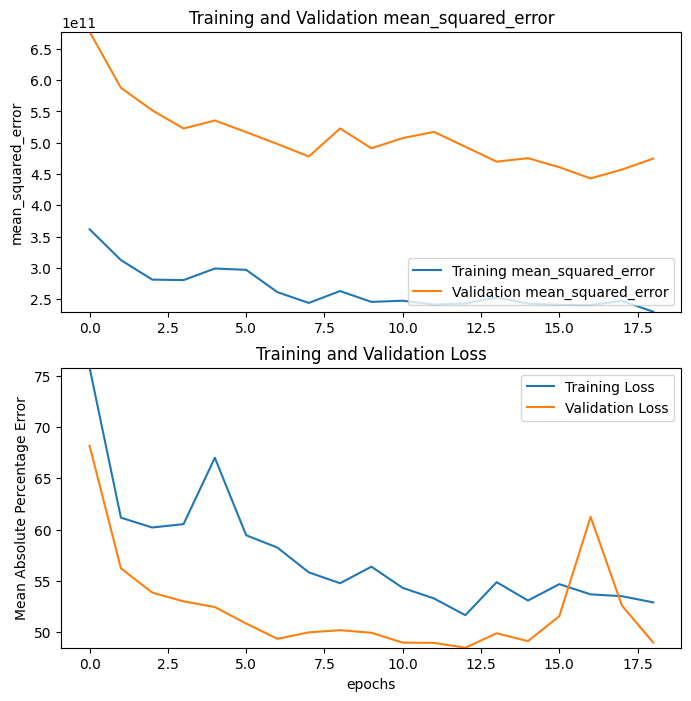

In [ ]:
# Tonen van model performance
model_performance(mm_history, 'mean_squared_error')

Het eerste model presteert niet geweldig op de loss (Mean Absolute Percentage Error) of de gekozen metric (Mean Squared Error). Door de toepassing van genoeg dropout en kernel regularisatie in het model is er wel gezorgd dat het model niet kon overfitten. Er is echter nog genoeg ruimte voor verbetering bij de score van het model.

Nu het model is beoordeeld kan de input data van de test-set worden gebruikt om de voorspelling te maken en deze in een CSV-bestand voor Kaggle te zetten.

In [ ]:
# CSV aanmaken voor kaggle
# kaggle_csv(multimodaal, [test_images_array, tabular_features_array], 'MultiModaalModel_4')

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step
voorspelling_MultiModaalModel_4_0321104330.csv has been saved!


[Terug naar boven](#begin)

### Tuning van het model

Nu de eerste upload van een multimodaal model is gelukt, is het tijd om het model te verbeteren door middel van optimalisatie technieken. De voornaamste techniek die hierbij gebruikt zal worden is hyperparameter tuning, door middel van keras_tuner. Om dit te doen wordt de model code in een functie gezet, waarbij we verschillende factoren kunnen invoeren als mogelijke parameters.

In [ ]:
def multimodaal_hpt(hp):
    # Input voor de afbeeldingen
    image_input = Input(shape=(1024, 1024, 3), name='Image input')

    # Keuze om regio te selecteren
    region_choice = hp.Choice('region', values=['top_left', 'top_right', 'bottom_left', 'bottom_right'])

    # Selecteren van regio afbeelding
    if region_choice == 'top_left':
        cropped_image = image_input[:, :512, :512, :]
    elif region_choice == 'top_right':
        cropped_image = image_input[:, :512, 512:, :]
    elif region_choice == 'bottom_left':
        cropped_image = image_input[:, 512:, :512, :]
    else: # region_choice == 'bottom_right'
        cropped_image = image_input[:, 512:, 512:, :]

    # Gebruik van een rescaling laag
    rescaling = Rescaling(1./255, name='Rescaling_Image')(cropped_image)

    # Loop om aantal lagen te bepalen
    for cl in range(hp.Int('conv_blocks', min_value=3, max_value=5, default=3)):
        # Parameter voor tuning aantal filters conv
        conv_filters = hp.Int(f'filters_{cl}', min_value=16, max_value=128, step=16)
        conv = Conv2D(
            filters=conv_filters, kernel_size=(3, 3),
            padding='same', activation='relu',
            name=f'Convolutional_{cl}'
            )(rescaling)

        # MaxPooling laag
        maxpool = MaxPooling2D(name=f'Pooling_{cl}')(conv)

        # Toevoegen van BatchNorm
        batchnorm = BatchNormalization(name=f'BatchNorm_{cl}')(maxpool)

        rescaling = batchnorm

    # Flatten laag
    flatten = Flatten(name='Flatten')(rescaling)

    # Input voor de tabulaire data
    tabular_input_laag = Input(shape=(5,), name='Tabel input')

    # Korte tussenstap tegen errors
    tabular_input = tabular_input_laag

    for dl in range(hp.Int('dense_blocks', min_value=3, max_value=5, default=3)):
        # Parameter voor tuning aantal neuronen dense
        dense_neurons = hp.Int(f'neurons_tabel_{dl}', min_value=16, max_value=128, step=16)
        dense = Dense(dense_neurons, activation='relu', name=f'Dense_Tabel_{dl}')(tabular_input)

        # Tunen van hoeveelheid dropout
        drop_amount = hp.Float(f'dropout_tabel_{dl}', min_value=0.1, max_value=0.3, step=0.05)
        dropout = Dropout(drop_amount, name=f'Dropout_tabel_{dl}')(dense)

        tabular_input = dropout

    # Concatenate laag om data te combineren
    concatenated = concatenate([flatten, tabular_input], name='Samenvoegen')

    for col in range(hp.Int('combi_blocks', min_value=2, max_value=3, default=2)):
        # Parameter voor tuning aantal neuronen
        dense_neurons = hp.Int(f'neurons_combi_{col}', min_value=16, max_value=128, step=16)
        dense = Dense(
            dense_neurons, activation='relu',
            name=f'Dense_Combi_{col}'
            )(concatenated)

        # Tunen van hoeveelheid dropout
        drop_amount = hp.Float(f'dropout_combi_{col}', min_value=0.1, max_value=0.3, step=0.05)
        dropout = Dropout(drop_amount, name=f'Dropout_Combi_{col}')(dense)

        concatenated = dropout

    # Parameter voor tuning aantal neuronen
    dense_neurons = hp.Int(f'neurons_combi_post', min_value=16, max_value=32, step=16)
    regularizer = hp.Choice('regularizer', values=['l1', 'l2'])
    dense = Dense(
        dense_neurons, activation='relu',
        name=f'Dense_Combi_post',
        kernel_regularizer=regularizer
        )(concatenated)

    # Tunen van hoeveelheid dropout
    drop_amount = hp.Float(f'dropout_post', min_value=0.1, max_value=0.3, step=0.05)
    dropout = Dropout(drop_amount, name=f'Dropout_Combi_post')(dense)

    # Output laag
    output_layer = Dense(1, activation='linear', name='Output')(dropout)

    # Maken van het model
    multimodaal = Model(inputs=[image_input, tabular_input_laag], outputs=output_layer)

    # Tuner maken voor learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

    # Compilen van het model
    multimodaal.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_absolute_percentage_error',
        metrics=['mean_squared_error']
    )

    return multimodaal

Nu de functie en de parameters zijn gedefineerd kan er gebruikt worden gemaakt van kt.Hyperband om het model op te stellen. Vervolgens kan de `.search()` methode worden gebruikt om alle mogelijke modellen te testen.

In [ ]:
# Aanmaken van de tuner
tuner = kt.Hyperband(
    multimodaal_hpt,
    objective=kt.Objective("val_loss", direction="min"),
    max_epochs=50,
    factor=3,
    directory='Model_2_tuning',
    project_name='hpt_tuning_multimodal'
)

# Begin met tunen
tuner.search(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stop, lr_scheduler]
)

Trial 90 Complete [00h 22m 18s]
val_loss: 100.21798706054688

Best val_loss So Far: 47.061767578125
Total elapsed time: 19h 55m 30s


Nu de tuner is uitgevoerd en opgeslagen (of opgehaald bij het opnieuw runnen van de cel) is het tijd om de beste parameters op te halen. Gelukkig kan dit gemakkelijk worden gedaan met behulp van de `get_best_hyperparameters()` method.

In [ ]:
# Ophalen van de beste hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=2)[0]

Aan de hand van de hyperparameters is het makkelijk om een model op te stellen dat zo optimaal mogelijk zou moeten werken. In de onderstaande cel staat 1 grote print statement, deze toont alle parameters op een overzichtelijke manier.

In [ ]:
print(f"""
De beste hyperparameters zijn gevonden.\n

De beste image regio is: {best_hps.get('region')}.\n

Het optimale aantal conv lagen is: {best_hps.get('conv_blocks')}.
Het optimaal aantal filters bij elke conv laag is: {
    ", ".join(str(best_hps.get(f'filters_{i}')) for i in range(best_hps.get('conv_blocks')))
    }.

Het optimale aantal Dense tabel lagen is: {best_hps.get('dense_blocks')}.
Het optimaal aantal neuronen bij elke dense tabel laag is: {
    ", ".join(str(best_hps.get(f'neurons_tabel_{i}')) for i in range(best_hps.get('dense_blocks')))
    }.
De optimale hoeveelheid dropout bij de dense tabel lagen is: {
    ", ".join(str(best_hps.get(f'dropout_tabel_{i}')) for i in range(best_hps.get('dense_blocks')))
    }.\n

Het optimale aantal Dense combi lagen is: {best_hps.get('combi_blocks')}.
Het optimaal aantal neuronen bij elke dense combi laag is: {
    ", ".join(str(best_hps.get(f'neurons_combi_{i}')) for i in range(best_hps.get('combi_blocks')))
    }.
De optimale hoeveelheid dropout bij de dense combi lagen is: {
    ", ".join(str(best_hps.get(f'dropout_combi_{i}')) for i in range(best_hps.get('combi_blocks')))
    }.\n

Het optimaal aantal neuronen bij de laatste dense combi laag is: {best_hps.get('neurons_combi_post')}.
De optimaal hoeveelheid dropout bij de laatste dense combi laag is: {best_hps.get('dropout_post')}.
De optimale regularisatie bij de laatste dense combi laag is: {best_hps.get('regularizer')}.

De optimale learning rate is: {best_hps.get('learning_rate')}.
""")


De beste hyperparameters zijn gevonden.

      
De beste image regio is: bottom_right.


Het optimale aantal conv lagen is: 5.
Het optimaal aantal filters bij elke conv laag is: 112, 16, 112, 16, 96.

Het optimale aantal Dense tabel lagen is: 4.
Het optimaal aantal neuronen bij elke dense tabel laag is: 112, 32, 16, 64.
De optimale hoeveelheid dropout bij de dense tabel lagen is: 0.25, 0.25, 0.25, 0.25.


Het optimale aantal Dense combi lagen is: 2.
Het optimaal aantal neuronen bij elke dense combi laag is: 96, 48.
De optimale hoeveelheid dropout bij de dense combi lagen is: 0.15000000000000002, 0.1.


Het optimaal aantal neuronen bij de laatste dense combi laag is: 16.
De optimaal hoeveelheid dropout bij de laatste dense combi laag is: 0.2.
De optimale regularisatie bij de laatste dense combi laag is: l1.

De optimale learning rate is: 0.01.



Ten opzichte van het eerder opgestelde model zijn er twee grootte aanpassingen. Deze zijn te vinden in het aantal lagen in de convolutional netwerk en in het gecombineerde netwerk. Bij beide delen van het model is het aantal lagen verhoogt. Daarnaast is er extra aandacht besteed aan het voorkomen van overfitting bij de afbeeldingen, door ook BatchNormilization toe te passen.

Voordat de nieuwe parameters gebruikt gaan worden zal er eerst een update komen aan de `early_stop`, aangezien er dit moment veel meer epochs zullen worden gebruikt. Ook zal de `lr_scheduler` worden aangepast, zodat deze wat later en minder sterk zal afdalen.

In [ ]:
# Aanpassen van early_stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Defineeren van de schedule
def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return float(lr * tf.math.exp(-0.75))

# Opzetten van de schedule
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

Met de nieuwe early stop kan de `.hypermodel.build()` method worden gebruikt om het beste model op te halen en aan te maken. Daarna kan het model gefit worden op de train data. Dit keer zullen er 2000 epochs worden uitgevoerd, echter zal dit waarschijnlijk eerder gestopt worden door de callbacks. De 2000 epochs is om het model genoeg tijd te geven om zo goed mogelijk te leren van de data.

In [ ]:
# Bouwen van het model
multimodaalhpt = tuner.hypermodel.build(best_hps)

# Invoeren aantal epochs
epochs = 2000

# Fitten van het model
mmhpt_history = multimodaalhpt.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stop, lr_scheduler])

Epoch 1/2000
100/100 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - loss: 89.3658 - mean_squared_error: 537370492928.0000 - val_loss: 66.8299 - val_mean_squared_error: 452644372480.0000 - learning_rate: 0.0100
Epoch 2/2000
100/100 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - loss: 64.8736 - mean_squared_error: 357584502784.0000 - val_loss: 57.8934 - val_mean_squared_error: 608319897600.0000 - learning_rate: 0.0100
Epoch 3/2000
100/100 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - loss: 65.5724 - mean_squared_error: 402861457408.0000 - val_loss: 57.0735 - val_mean_squared_error: 598033825792.0000 - learning_rate: 0.0100
Epoch 4/2000
100/100 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - loss: 65.4926 - mean_squared_error: 365255622656.0000 - val_loss: 59.7703 - val_mean_squared_error: 619359109120.0000 - learning_rate: 0.0100
Epoch 5/2000
100/100 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - loss: 63.6526 - mean_squared_error: 388148166656.0000 - val_loss: 58.4056 - val_mean_squared_error: 592272818176.0000 - learning_rate: 0.0100
Epoch

Met het gefitte model kan er weer gekeken worden naar de performance grafieken.

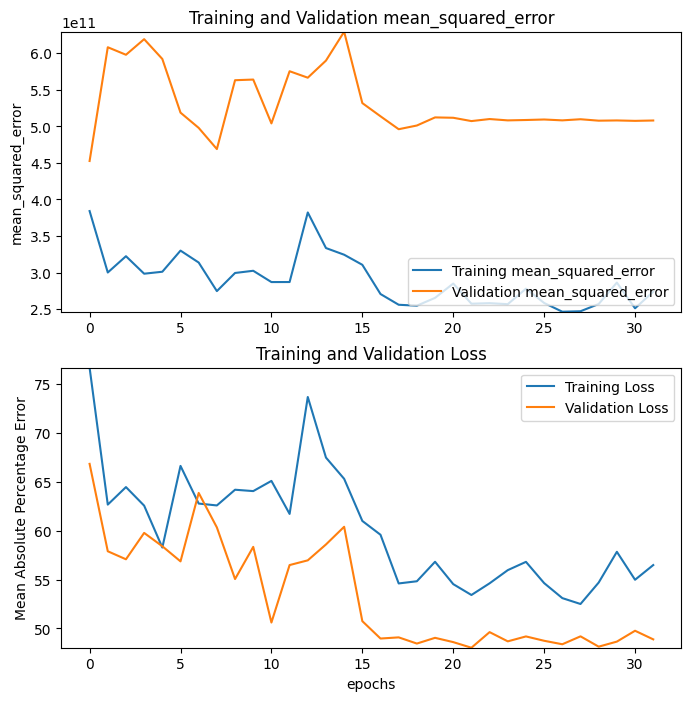

In [ ]:
# Tonen van model performance
model_performance(mmhpt_history, 'mean_squared_error')

Het getunede model presteert marginaal beter dan het ongetunede model. Wat wel duidelijk te zien is, is dat de learning rate scheduler (die ingaat na epoch 15) een sterk effect heeft op de schommelingen van het model. Verder is er ook bij dit model geen sprake van overfitting op de train data.

Nu alles is uitgevoerd kan de voorspelling van het model worden gedaan op de test data en kan het geupload worden naar Kaggle.

In [ ]:
# CSV voor kaggle aanmaken
kaggle_csv(multimodaalhpt, [test_images_array, tabular_features_array], 'MultiModaalModel_postHPT_2')

NameError: name 'kaggle_csv' is not defined

[Terug naar boven](#begin)

## H8: Bevindingen <a name='h8'></a>

In het notebook zijn er uiteindelijk zo'n NADER INVULLEN volledige modellen getraint en getest. De modellen gaven de volgende resultaten:

|Model|MAPE-score Train|MAPE-score Validatie
|--|--|--
|FCNN-Basis|26.1245|29.2936
|FCNN-Tuned|INVULLEN|INVULLEN
|CNN-Basis|INVULLEN|INVULLEN
|CNN-Tuned|INVULLEN|INVULLEN
|Transfer-Basis|INVULLEN|INVULLEN
|Transfer-Tuned|INVULLEN|INVULLEN
|Multimodaal-Basis|52.6166|48.4958
|Multimodaal-Tuned|53.5891|48.0319

INVULLEN Tabel INVULLEN

Naast dat de modellen in het notebook zijn getest op de validatieset, zijn de modellen ook getest op de testset. Om de scores van de testset te kunnen bekijken is het nodig om de voorspellingen up te loaden naar Kaggle. Hier zijn de resultaten ervan:

|Model|Kaggle Score
|--|--
|FCNN-Basis|0.48185
|FCNN-Tuned|INVULLEN
|CNN-Basis|INVULLEN
|CNN-Tuned|INVULLEN
|Transfer-Basis|INVULLEN
|Transfer-Tuned|INVULLEN
|Multimodaal-Basis|0.62910
|Multimodaal-Tuned|0.61235

INVULLEN Tabel of Afbeeldingen toevoegen ipv tabel INVULLEN

### Beste model !!AANPASSEN INDIEN NODIG!!

Het model dat het beste presteert, zowel in het notebook als op Kaggle, is het basis FCNN model. Dit model beschikt over een score van 26.1245 op de train set, 29.2935 op de validatieset en 48.158 als publieke score op de test van Kaggle. Met deze scores is het model de enige die onder de 50 Mean Absolute Percentage Error komt op Kaggle. Deze score is behaald met de volgende parameters binnen het model:

Parameters van de lagen:
|Laag|Neuronen|Activatie
|--|--|--
|Input|5|n.v.t.
|Dense_1|128|ReLU
|Dense_2|64|ReLU
|Dense_3|64|ReLU
|Dense_4|16|ReLU
|Output|1|Linear

Parameters van de Compile:
|Optimizer|Loss|Metric
|--|--|--
|Adam met lr 0.001|'mean_absolute_percentage_error'|'mean_squared_error'

Parameters van de fit:
|batch_size|epochs|callbacks
|--|--|--
|4|5000|early_stop: patience van 50

[Terug naar boven](#begin)

## H9: Uitdagingen <a name='h9'></a>

Tijdens het modeleren begon het erg soepel. Voor het maken van het Fully Connected Neural Network was er geen probleem om de data soepel door te voeren aan het model. De echte uitdagingen begonnen bij het aanmaken van de dataset voor de afbeeldingen, en daarna ook bij de dataset voor het multimodale model. De dataset voor de afbeeldingen bestond eerst uit een reguliere pandas dataframe die de NumPy Arrays bevat, echter zorgde dit dat het model te zwaar werd. Later is er gebruik gemaakt van de `tf.keras.utils.image_dataset_from_directory`, waarmee de afbeeldingen direct in een tensor geladen werdt. Op deze manier was er veel minder kracht nodig vanuit onze laptops.

Bij het multimodale model zat de uitdaging voornamelijk in het herontwerpen van de input. Omdat er tabel en afbeelding data bij elkaar gevoegd moest worden, was dit een nieuwe uitdaging. Door gebruik te maken van lesstof, gecombineerd met de kennis van de tabel, was het gemakkelijk om de train data en de validatie data op te stellen. Voor de test data wilde deze code echter niet werken, maar na wat rondspelen is het gelukt. Door de data niet in een gezamenlijke tensor te stoppen, maar juist in twee NumPy Arrays. Deze NumPy Arrays zijn vervolgens doorgevoerd als de input voor de testset.

Daarnaast is de score niet optimaal. Met een beste score van 48 MAPE is er nauwelijks sprake van goede, concrete voorspellingen. Het model presteert net goed genoeg om een bruikbare voorspelling te kunnen maken, echter zou het model liever richting de score van 20 MAPE gaan. Rondom deze score begint het model sterke voorspellingen te genereren die ook goed bruikbaar zijn in de echte wereld.

EVENTUEEL AANVULLEN MET EXTRA UITDAGING DIE ONDERVONDEN ZIJN

[Terug naar boven](#begin)

## H10: Conclusie en aanbevelingen <a name='h10'></a>

### Conclusie

Het doel van dit project was om uit te zoeken welk model het beste is om de huizenmarkt te helpen, door huisprijzen te voorspellen. Na meerdere modellen geprobeerd te hebben, bleek een simpeler Fully Connected Neural Network de beste optie te zijn. AANVULLEN MET TEKST OMTREND SLECHTSTE MODEL EN WAAROM DEZE VERSCHILLEN AANWEZIG ZIJN.

### Aanbevelingen

Omdat er maar 1 model onder de 50 MAPE is gekomen, is de aanbeveling om te gaan voor het simpelere Neurale Netwerk. Voor de makelaars scheelt dit kostbare tijd die ze mogelijk moeten nemen om een gecompliceerder model te begrijpen en zal het tijd schelen bij het maken van voorspellingen. Ook voor de huizenmarkt (de kopers en verkopers) kan een simpeler model handiger uitkomen. De meeste mensen beschikken ook niet over de sterkste hardware en zullen weinig gebruik kunnen maken van zware, gecompliceerde modellen. Door het simpelere model te gebruiken is het model beter te begrijpen en te gebruiken. EVENTUEEL AANVULLEN OF AANPASSEN AFHANKELIJK VAN AANPASSINGEN BIJ MODELLEN

[Terug naar boven](#begin)